In [1]:
import os
import shutil
import warnings
import pickle
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import xarray as xr
import joblib
import math
import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from data_loading import create_xarr, mad, create_label_df
from utils import DateIter

%matplotlib inline

In [2]:
import yaml

from bokeh.layouts import layout, column
from bokeh.models import Div, RangeSlider, Spinner, ColumnDataSource, Slider
from bokeh.plotting import figure, show, curdoc
from bokeh.transform import linear_cmap
from bokeh.io import show, output_notebook
from bokeh.themes import Theme
from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

Loading BokehJS ...

In [3]:
plt.rcParams['font.size']           = 18
plt.rcParams['font.weight']         = 'bold'
plt.rcParams['axes.titleweight']    = 'bold'
plt.rcParams['axes.labelweight']    = 'bold'
plt.rcParams['axes.xmargin']        = 0

In [4]:
parent_dir     = 'data_files'
data_out_path  = 'processed_data/full_data.joblib'

# Load in CSV Histograms ###############
if not os.path.exists(data_out_path):
    full_xarr = create_xarr(
        parent_dir=parent_dir,
        expected_shape=(720, 300),
        dtype=(np.uint16, np.float32),
        apply_fn=mad,
        plot=False,
    )
    joblib.dump(full_xarr, data_out_path)

date_iter = DateIter(data_out_path) #, label_df=label_out_path)

In [5]:
def fmt_xaxis(ax,xlim=None,label=True):
    ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H%M"))
    ax.set_xlabel('Time [UTC]')
    ax.set_xlim(xlim)

def plot_heatmap(times,ranges_km,arr,xlim=None,cb_pad=0.04):
    # Plot Heatmap #########################
    fig     = plt.figure(figsize=(18,5))
    ax      = fig.add_subplot(1,1,1)
    ax.set_title(f'| {date} |')
    mpbl = ax.pcolormesh(times,ranges_km,arr,cmap='plasma')
    plt.colorbar(mpbl,label='Radio Spots',aspect=10,pad=cb_pad)
    fmt_xaxis(ax,xlim)
    ax.set_ylabel('Range [km]')
    ax.set_ylim(500,2000)
    plt.show()
    plt.close()

def my_sin(tt_sec, freq, amplitude, phase, offset):
    # create the function we want to fit
    result = amplitude * np.sin( (2*np.pi*tt_sec*freq )+ phase ) + offset
    return result

def load_spots(date, x_trim=.08333, y_trim=.08,sigma=4.2):
    arr = date_iter.get_date(date,raise_missing=False)
    if arr is None:
        warnings.warn(f'Date {date} has no input')
        return
        
    xl_trim, xrt_trim   = x_trim if isinstance(x_trim, (tuple, list)) else (x_trim, x_trim)
    yl_trim, yr_trim    = x_trim if isinstance(y_trim, (tuple, list)) else (y_trim, y_trim)
    xrt, xl             = math.floor(xl_trim * arr.shape[0]), math.floor(xrt_trim * arr.shape[0])
    yr, yl              = math.floor(yl_trim * arr.shape[1]), math.floor(yr_trim * arr.shape[1])
    arr                 = arr[xrt:-xl, yr:-yl]

    ranges_km   = arr.coords['height'].values
    times       = [date + x for x in pd.to_timedelta(arr.coords['time'])]
    arr         = np.nan_to_num(arr, nan=0)
    arr         = gaussian_filter(arr.T, sigma=(sigma, sigma))

    # Plotting Code ################################################################ 
    # X-Limits for plotting
    x_0     = date + datetime.timedelta(hours=12)
    x_1     = date + datetime.timedelta(hours=24)
    xlim    = (x_0, x_1)

    result = {}
    result['arr']       = arr
    result['times']     = times
    result['ranges_km'] = ranges_km
    result['xlim']      = xlim    
    return result

# matplotlib Output

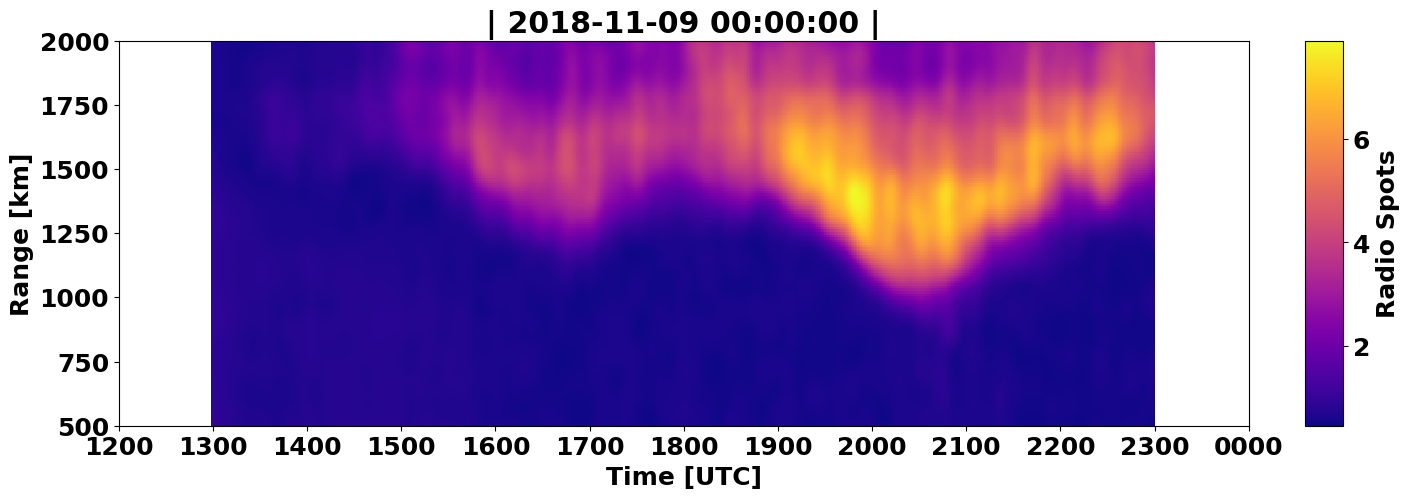

In [6]:
date   = datetime.datetime(2018,11,9)
result = load_spots(date)
plot_heatmap(**result)

# Bokeh Output - No Bokeh Server

In [7]:
# from bokeh.models import LogColorMapper
import bokeh.models

In [8]:
# fill_color   = linear_cmap('counts', 'Viridis256', 0, max(bins.counts))
# color_mapper = LogColorMapper(palette="Viridis256", low=1, high=1e7)
color_mapper = bokeh.models.LinearColorMapper(palette="Viridis256", low=0, high=10)

In [9]:
times     = result['times']
ranges_km = result['ranges_km']
image     = result['arr']

x_range   = result['xlim']
y_range   = (min(ranges_km), max(ranges_km))
title     = date.strftime('%Y %b %d')
plot  = figure(x_range=x_range, y_range=y_range, title=title,
               toolbar_location='below', width=1000, height=500)

yy        = min(ranges_km)
dh        = np.ptp(ranges_km)
xx        = min(times)
dw        = max(times) - min(times)
r         = plot.image(image=[image], color_mapper=color_mapper,dh=dh, dw=dw, x=xx, y=yy)


tt_sec    = np.array([(x-x_range[0]).total_seconds() for x in times])
T_hr      = datetime.timedelta(hours=3)
freq      = 1./(T_hr.total_seconds())
amplitude = 200.
phase     = 0.
offset    = 1400.
sinFit    =  my_sin(tt_sec, freq, amplitude, phase, offset)
plot.line(x=times,y=sinFit,line_color='white',line_width=2,line_dash='dashed')

color_bar = r.construct_color_bar(padding=1)
plot.add_layout(color_bar, "right")
show(plot)

# Bokeh Output - With Bokeh Server

In [10]:
def bkapp(doc):
    df     = sea_surface_temperature.copy()
    source = ColumnDataSource(data=df)

    plot   = figure(x_axis_type='datetime', y_range=(0, 25),
                  y_axis_label='Temperature (Celsius)',
                  title="Sea Surface Temperature at 43.18, -70.43")
    plot.line('time', 'temperature', source=source)

    def callback(attr, old, new):
        if new == 0:
            data = df
        else:
            data = df.rolling('{0}D'.format(new)).mean()
        source.data = ColumnDataSource.from_df(data)

    slider = Slider(start=0, end=30, value=0, step=1, title="Smoothing by N Days")
    slider.on_change('value', callback)

    doc.add_root(column(slider, plot))

    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 800
            Grid:
                grid_line_dash: [6, 4]
                grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp) # notebook_url="http://localhost:8888" 

In [11]:
def bkapp(doc):
    times     = result['times']
    ranges_km = result['ranges_km']
    image     = result['arr']
    
    x_range   = result['xlim']
    y_range   = (min(ranges_km), max(ranges_km))
    title     = date.strftime('%Y %b %d')
    
    plot      = figure(x_range=x_range, y_range=y_range, title=title)
    
    yy        = min(ranges_km)
    dh        = np.ptp(ranges_km)
    xx        = min(times)
    dw        = max(times) - min(times)
    color_mapper = bokeh.models.LinearColorMapper(palette="Viridis256", low=0, high=10)
    r         = plot.image(image=[image], color_mapper=color_mapper,dh=dh, dw=dw, x=xx, y=yy)

    color_bar = r.construct_color_bar(padding=1)
    plot.add_layout(color_bar, "right")

    tt_sec    = np.array([(x-x_range[0]).total_seconds() for x in times])
    def my_sin2(T_hr=3, amplitude=200, phase=0, offset=1400.):
        # create the function we want to fit
        freq   = 1./(datetime.timedelta(hours=T_hr).total_seconds())
        result = amplitude * np.sin( (2*np.pi*tt_sec*freq )+ phase ) + offset
        data   = pd.DataFrame({'curve':result},index=times)
        data.index.name = 'time'
        return data

    T_hr      = 4
    data      =  my_sin2(T_hr=T_hr)
    source    = ColumnDataSource(data=data)
    plot.line('time','curve',source=source,line_color='white',line_width=2,line_dash='dashed')
    
    def callback(attr, old, new):
        source_new = my_sin2(T_hr=new)
        source.data = ColumnDataSource.from_df(source_new)

    slider = Slider(start=0.1, end=10, value=T_hr, step=0.1, title="Period [hr]:")
    slider.on_change('value', callback)

    doc.add_root(column(slider, plot))
    
    doc.theme = Theme(json=yaml.load("""
        attrs:
            figure:
                # background_fill_color: "#DDDDDD"
                outline_line_color: white
                toolbar_location: above
                height: 500
                width: 1000
            Grid:
                grid_line_dash: [6, 4]
                # grid_line_color: white
    """, Loader=yaml.FullLoader))

show(bkapp) # notebook_url="http://localhost:8888" 